In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2

See [here](https://planetlabs.github.io/planet-client-python/api/reference.html) for an API reference 

# 0. Imports

In [2]:
import shapely.geometry
import planet.api
import tqdm
import logging

from src.utils.logging import get_logger
from src.utils.os import list_content
from src.constants import PLANET_API_KEY, DATA_PATH

logger = get_logger(__name__)
logger.setLevel(logging.INFO)

# 1. Set up planet client and region of interest

In [3]:
assert PLANET_API_KEY is not None
planet_client = planet.api.ClientV1(api_key=PLANET_API_KEY)

In [4]:
# Coordinates in WGS84 coordinate system
lat = -5.3494
lon = -56.0282
height = 1
width = 1

roi = shapely.geometry.box(lon - width/2, lat - height/2, lon + height/2, lat + width/2)

# 2. Select relevant mosaic to query

We first start by looking at all the mosaics (aggregated data products) that are available for our user. In our case we are interested in data from 2019, which overlaps with our GEDI data. Let us therefore look for all mosaics which contain 2019 in their name.

In [5]:
mosaics_result = planet_client.get_mosaics(name_contains=2019)
available_mosaics = list(mosaics_result.items_iter(limit=None))    
print(f"Found {len(available_mosaics)} mosaics for 2019:")
for mosaic in available_mosaics:
    print(f"\t{mosaic['name']}")

Found 3 mosaics for 2019:
	planet_medres_normalized_analytic_2018-12_2019-05_mosaic
	planet_medres_normalized_analytic_2019-06_2019-11_mosaic
	planet_medres_normalized_analytic_2019-12_2020-05_mosaic


How does one of these mosaic responses look like? Let's look at the keys of the first one:

In [6]:
available_mosaics[0].keys()

dict_keys(['_links', 'bbox', 'coordinate_system', 'datatype', 'first_acquired', 'grid', 'id', 'interval', 'item_types', 'last_acquired', 'level', 'name', 'product_type', 'quad_download'])

We can see a few interesting things here:  

1. The item type is `PSScene4Band` which stands for [Planet scope](https://earth.esa.int/eogateway/missions/planetscope) (a planet satellite constellation- details in screenshot below) and specifically to the 4 band product of it (RGB + near infrared).  
2. Level 15: The zoom level. Level 15 means we get about 4.7m resolution GSD at the equator.  
3. Quad size and resolution: The number of pixels per quad axis (quadratic) as well as the corresponding GSD of 4.777m.   
4. The date of the first and last acquired scenes which were combined to make the quads (which in turn make up the mosaic): from 1 Dec 2018 to 1 Jun 2019.

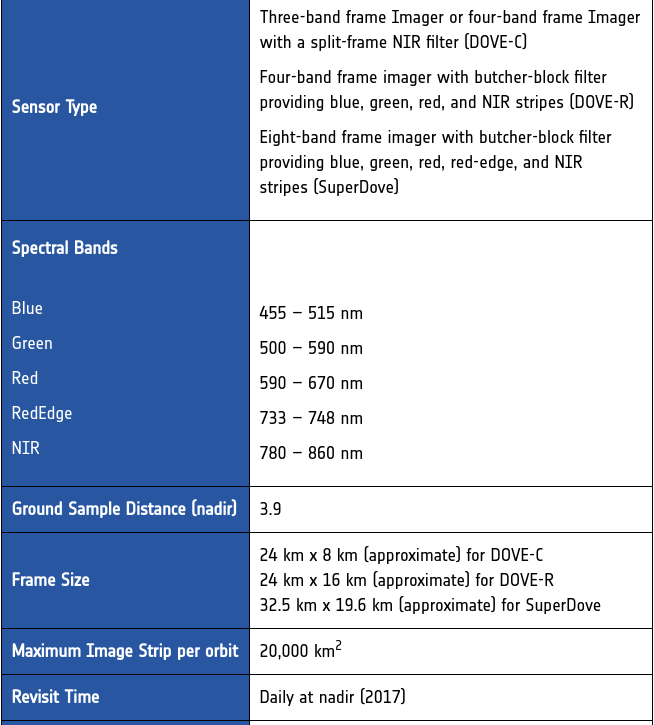

For our demo purposes, we will use the 2019_Jan_to_Jun mosaic

In [7]:
relevant_mosaic = available_mosaics[0]

# 3. Find out which quads of the mosaic overlap with our ROI

Next, we check which quads (quadratic tiles) of the mosaic overlap with our region of interest.

In [8]:
quad_result = planet_client.get_quads(relevant_mosaic, bbox=roi.bounds)
roi_quads = list(quad_result.items_iter(limit=None))
print(f"Found {len(roi_quads)} relevant quads in given mosaic `{relevant_mosaic['name']}` which overlap with ROI")

Found 49 relevant quads in given mosaic `planet_medres_normalized_analytic_2018-12_2019-05_mosaic` which overlap with ROI


# 4. Finally, let us download the quads to our folder of choice

In [9]:
planet_path = DATA_PATH / "Planet"

mosaic_path = planet_path / relevant_mosaic['name']
mosaic_path.mkdir(parents=True, exist_ok=True)

assert mosaic_path.exists()

In [10]:
mosaic_path

PosixPath('/gws/nopw/j04/forecol/data/Planet/planet_medres_normalized_analytic_2018-12_2019-05_mosaic')

In [11]:
progress_bar = tqdm.tqdm(roi_quads, position=0, leave=True)
logger.info(f"Downloading to: {mosaic_path}")
for quad in progress_bar:
    progress_bar.set_description(f"Downloading quad {quad['id']}")
    
    # Check if quad already downloaded:
    east_pos, north_pos = quad["id"].split("-")
    matching_quads = list(mosaic_path.glob(f"*{east_pos.zfill(4)}E-{north_pos.zfill(4)}N*.tif"))
    if len(matching_quads) == 1:
        logger.debug(f"Already downloaded: {matching_quads[0]}")
        continue
    elif len(matching_quads) > 1:
        logger.error(f"Found multiple matching quads {matching_quads[0]}")
        raise RuntimeError
        
    # If not, download it ... 
    quad_download_response = planet_client.download_quad(quad)
    body = quad_download_response.get_body()
    
    # ... and save it
    progress_bar.set_description(f"Saving quad {quad['id']}")
    body.write(file=mosaic_path / body.name)

  0%|          | 0/49 [00:00<?, ?it/s]

2021-05-10 16:04:45,373 INFO: Downloading to: /gws/nopw/j04/forecol/data/Planet/planet_medres_normalized_analytic_2018-12_2019-05_mosaic [in <module> at <ipython-input-11-ed555d45cb1b>:2]


# 5. Let us look at a sample quad

In [12]:
downloaded_quads = list_content(mosaic_path)

sample_quad_path = downloaded_quads[0]

In [13]:
import rioxarray as rxr
sample_quad = rxr.open_rasterio(sample_quad_path)

In [14]:
sample_quad

<xarray.DataArray (band: 5, y: 4096, x: 4096)>
[83886080 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * y            (y) float64 -6.457e+05 -6.457e+05 ... -6.653e+05 -6.653e+05
  * x            (x) float64 -6.301e+06 -6.301e+06 ... -6.281e+06 -6.281e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

We can see there are 4096 x 4096 pixels in this quad and 5 available bands (B, G, R, NIR, Alpha).

Here's more information directly from the [Planet PlanetScope data specification](https://developers.planet.com/docs/data/sr-basemaps/). For more details see [here](https://assets.planet.com/products/basemap/planet-basemaps-product-specifications.pdf)
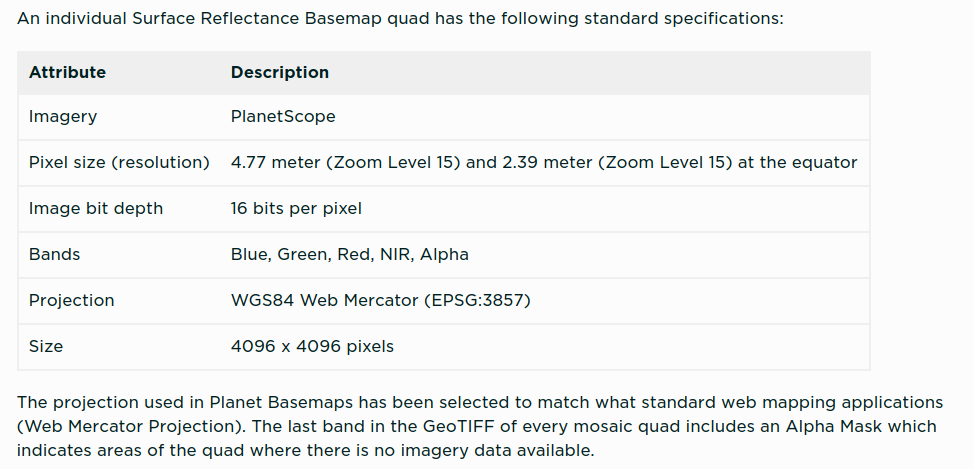

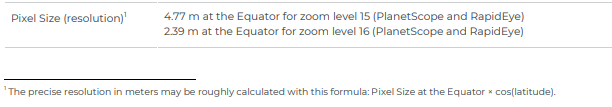

In [15]:
sample_quad

<xarray.DataArray (band: 5, y: 4096, x: 4096)>
[83886080 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * y            (y) float64 -6.457e+05 -6.457e+05 ... -6.653e+05 -6.653e+05
  * x            (x) float64 -6.301e+06 -6.301e+06 ... -6.281e+06 -6.281e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [59]:
import numpy as np
import matplotlib.pyplot as plt

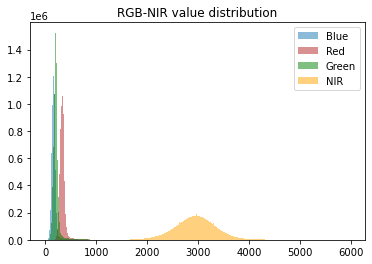

In [93]:
plt.hist(sample_quad[0,...].data.flatten(), bins=500, color="C0", alpha=0.5, label="Blue");
plt.hist(sample_quad[1,...].data.flatten(), bins=500, color="firebrick", alpha=0.5, label="Red");
plt.hist(sample_quad[2,...].data.flatten(), bins=500, color="green", alpha=0.5, label="Green");
plt.hist(sample_quad[3,...].data.flatten(), bins=500, color="orange", alpha=0.5, label="NIR");
plt.legend()
plt.title("RGB-NIR value distribution")
plt.show()

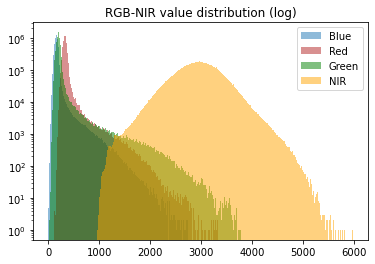

In [94]:
plt.hist(sample_quad[0,...].data.flatten(), bins=500, color="C0", alpha=0.5, label="Blue");
plt.hist(sample_quad[1,...].data.flatten(), bins=500, color="firebrick", alpha=0.5, label="Red");
plt.hist(sample_quad[2,...].data.flatten(), bins=500, color="green", alpha=0.5, label="Green");
plt.hist(sample_quad[3,...].data.flatten(), bins=500, color="orange", alpha=0.5, label="NIR");
plt.semilogy()
plt.legend()
plt.title("RGB-NIR value distribution (log)")
plt.show()

In [78]:
sample_quad[4,...].data.flatten() # alpha value

array([65535, 65535, 65535, ..., 65535, 65535, 65535], dtype=uint16)

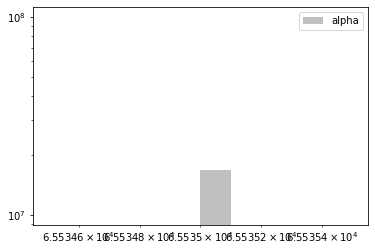

In [92]:
plt.hist(sample_quad[4,...].data.flatten(), bins=10, color="grey", alpha=0.5, label="alpha");
plt.legend()
plt.loglog()
plt.show();

Let's display the raster RGB data

In [95]:
import folium
import tqdm
import folium.features
import folium.plugins

# Create map and add layers
world_map = folium.Map(location=roi.centroid.coords[0][::-1],
                       control_scale=True,
                       zoom_start=8, 
                       tiles="OpenStreetMap")

# Add minimap
folium.plugins.MiniMap(zoom_level_fixed=2).add_to(world_map)

# Add ROI
ROI_STYLE = {'fillColor': '#2a74ac', 'color': '#2a74ac'}
folium.GeoJson(data=roi.__geo_interface__, 
                name="Region of interest",
                style_function= lambda x: ROI_STYLE).add_to(world_map)

# Add ESRI background tiles
folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    name = 'Esri Satellite',
    overlay = False,
    control = True
   ).add_to(world_map)

# Add Planet background tiles
folium.TileLayer(
    tiles = "https://tiles.planet.com/basemaps/v1/planet-tiles/planet_medres_normalized_analytic_2018-12_2019-05_mosaic/gmap/{z}/{x}/{y}.png?api_key=" + PLANET_API_KEY,
    attr = 'Planet_dec18_may19',
    name = 'Planet Basemap Dec18-May19',
    overlay = False,
    control = True
   ).add_to(world_map)

folium.TileLayer(
    tiles = "https://tiles.planet.com/basemaps/v1/planet-tiles/planet_medres_normalized_analytic_2019-06_2019-11_mosaic/gmap/{z}/{x}/{y}.png?api_key=" + PLANET_API_KEY,
    attr = 'Planet_jun19_nov19',
    name = 'Planet Basemap Jun19-Nov19',
    overlay = False,
    control = True
   ).add_to(world_map)

folium.TileLayer(
    tiles = "https://tiles.planet.com/basemaps/v1/planet-tiles/planet_medres_normalized_analytic_2019-12_2020-05_mosaic/gmap/{z}/{x}/{y}.png?api_key=" + PLANET_API_KEY,
    attr = 'Planet_dec19_may20',
    name = 'Planet Basemap Dec19-May20',
    overlay = False,
    control = True
   ).add_to(world_map)

folium.LayerControl().add_to(world_map)

world_map

# Legacy

In [14]:
aoi = {
  "type": "Polygon",
  "coordinates": [
    [
      [-122.54, 37.81],
      [-122.38, 37.84],
      [-122.35, 37.71],
      [-122.53, 37.70],
      [-122.54, 37.81]
    ]
  ]
}

In [18]:
query = planet.api.filters.and_filter(
    planet.api.filters.geom_filter(aoi),
    planet.api.filters.range_filter('cloud_cover', gt=0),
)

In [19]:
query

{'type': 'AndFilter',
 'config': ({'field_name': 'geometry',
   'type': 'GeometryFilter',
   'config': {'type': 'Polygon',
    'coordinates': [[[-122.54, 37.81],
      [-122.38, 37.84],
      [-122.35, 37.71],
      [-122.53, 37.7],
      [-122.54, 37.81]]]}},
  {'field_name': 'cloud_cover', 'type': 'RangeFilter', 'config': {'gt': 0}})}

In [21]:
# build a request for only PlanetScope imagery
request = planet.api.filters.build_search_request(
    query, item_types=['PSScene4Band']
)

In [22]:
request

{'item_types': ['PSScene3Band', 'PSScene4Band'],
 'filter': {'type': 'AndFilter',
  'config': ({'field_name': 'geometry',
    'type': 'GeometryFilter',
    'config': {'type': 'Polygon',
     'coordinates': [[[-122.54, 37.81],
       [-122.38, 37.84],
       [-122.35, 37.71],
       [-122.53, 37.7],
       [-122.54, 37.81]]]}},
   {'field_name': 'cloud_cover', 'type': 'RangeFilter', 'config': {'gt': 0}})}}

In [23]:
result = planet_client.quick_search(request)

In [24]:
result

In [18]:
#for item in result.items_iter(limit=None):
    #props = item['properties']
    #print('{0},{cloud_cover},{acquired}\n'.format(item['id'], **props))